## Vision Transformer - V2

In [51]:
import glob
import os
import random
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

warnings.filterwarnings('ignore')


In [52]:
%run data.ipynb

Total Trainable Data:  5606
Training set size:  60
Validation set size:  20
Test set size:  20
Found 49 validated image filenames belonging to 15 classes.
Found 17 validated image filenames belonging to 15 classes.
Found 15 validated image filenames belonging to 15 classes.


In [53]:
gpus = tf.config.list_physical_devices('GPU')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    if gpus:
        device = '/GPU:0'  # Use the first GPU if available
    else:
        device = '/CPU:0'  # Use CPU if no GPU is available
print("Using device:", device)

Using device: /CPU:0


In [54]:
def mlp(x, hidden_units, dropout_rate, regularizer_rate=0.01):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu, kernel_regularizer=l2(regularizer_rate))(x)
        x = Dropout(dropout_rate)(x)
    return x

In [55]:
from tensorflow.keras import layers

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config

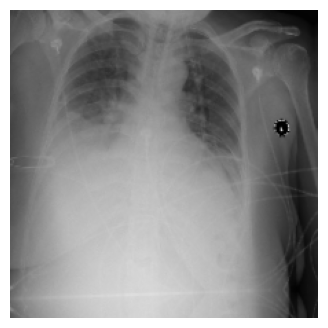

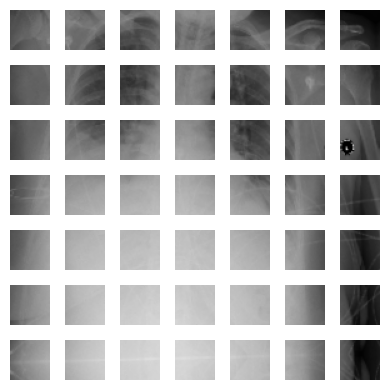

In [56]:
for image_batch, label_batch in train_generator:
    image = image_batch[0] 
    break 

image_size = 224
patch_size = 32  
num_patches = (image_size // patch_size) ** 2

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

image_tensor = tf.expand_dims(image, 0) 

patches_layer = Patches(patch_size)
patches = patches_layer(image_tensor)

patches_numpy = patches.numpy()
if np.max(patches_numpy) <= 1.0:
    patches_numpy *= 255  
patches_numpy = patches_numpy.astype('uint8') 

n = int(np.sqrt(num_patches))
plt.figure(figsize=(4, 4))
for i in range(n * n):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patches_numpy[0, i].reshape(patch_size, patch_size, 3)
    plt.imshow(patch_img)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [57]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [58]:
num_patches = (image_size // patch_size) ** 2
projection_dim = 64

patch_encoder = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)

encoded_patches = patch_encoder(patches)

input_shape = (224, 224, 3)  
patch_size = 32             
num_patches = (224 // patch_size) ** 2  
projection_dim = 64          
num_heads = 4                
transformer_units = [
    projection_dim * 2,      
    projection_dim,
]
transformer_layers = 8       
mlp_head_units = [2048, 1024]  
num_classes = len(parser.labels)  
test_datagen = ImageDataGenerator(rescale=1./255)

In [59]:
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-5
num_epochs = 10

In [60]:
# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=False,
)

# Choose an optimizer
optimizers = {
    "adam": keras.optimizers.Adam(learning_rate=learning_rate),
    "adamw": keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
    "sgd": keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=weight_decay),
    "sgd_momentum": keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
    "adagrad": keras.optimizers.Adagrad(learning_rate=learning_rate),
    "rmsprop": keras.optimizers.RMSprop(learning_rate=learning_rate)
}

optimizer = optimizers["sgd"]
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [61]:
def create_vit_classifier():
    inputs = Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, transformer_units, dropout_rate=0.1, regularizer_rate=0.01)
        encoded_patches = Add()([x3, x2])
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    features = mlp(representation, mlp_head_units, dropout_rate=0.5, regularizer_rate=0.01)
    logits = Dense(num_classes, activation='sigmoid')(features)
    model = Model(inputs=inputs, outputs=logits)
    return model

In [62]:
def run_experiment(model):
    model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ]
    )

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=validation_generator,
        callbacks=[ModelCheckpoint(os.path.join("files", "model.keras"), monitor='val_loss', verbose=1, save_best_only=True), 
                   early_stopping_callback, lr_scheduler],
    )


    return history

In [63]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.4638 - auc: 0.4228 - loss: 53.0949
Epoch 1: val_loss improved from inf to 52.41267, saving model to files/model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4824 - auc: 0.4345 - loss: 53.0596 - val_accuracy: 0.8902 - val_auc: 0.5782 - val_loss: 52.4127 - learning_rate: 0.0100
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7810 - auc: 0.5165 - loss: 52.5168
Epoch 2: val_loss improved from 52.41267 to 52.20943, saving model to files/model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 610ms/step - accuracy: 0.7864 - auc: 0.5342 - loss: 52.4968 - val_accuracy: 0.8902 - val_auc: 0.7113 - val_loss: 52.2094 - learning_rate: 0.0100
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8943 - auc: 0.6818 - loss: 52.1834
Epoch 3: val_loss improved from 52.20943 to 52.04490, saving model to files/model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.8878 - auc: 0.6723 - loss: 52.1873 - val_accurac

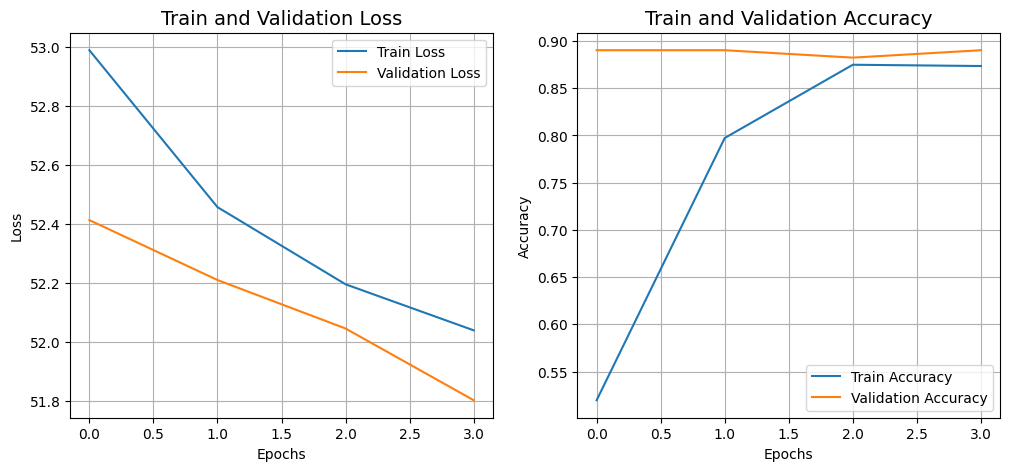

In [64]:
def plot_combined_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2) 
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # plt.savefig('combined_history.png')
    plt.show()

plot_combined_history(history)

In [65]:
test_generator.reset()
steps = int(np.ceil(len(test_generator.filenames) / test_generator.batch_size))
predictions = vit_classifier.predict(test_generator, steps=steps, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


In [66]:
loss, test_accuracy, test_auc = vit_classifier.evaluate(test_generator, steps=len(test_generator), verbose=0)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test AUC: {:.2f}".format(test_auc))
print("Test loss: {:.2f}".format(loss))


Test accuracy: 91.11%
Test AUC: 0.77
Test loss: 51.71


In [67]:
def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple', 'cyan', 'magenta', 'yellow', 'lime'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Label Classification')
    plt.legend(loc="lower right")
    plt.savefig("roc_curveV2.png")
    plt.show()

Shape of y_true: (15, 15)
Shape of predictions: (15, 15)


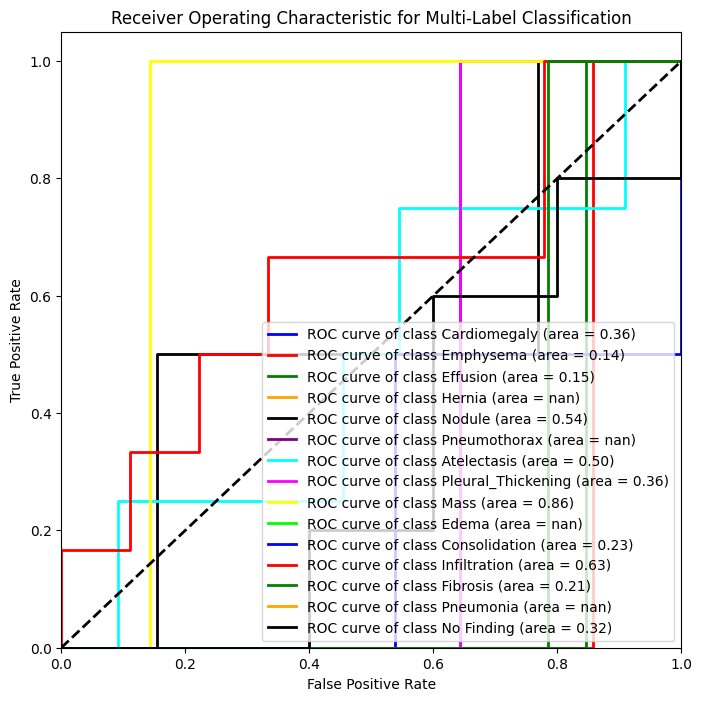

In [68]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=parser.labels)
y_true = mlb.fit_transform(val['Label'])
if y_true.shape[0] > predictions.shape[0]:
    y_true = y_true[:predictions.shape[0], :]

print("Shape of y_true:", y_true.shape)
print("Shape of predictions:", predictions.shape)

plot_roc_curves(y_true, predictions, num_classes=len(parser.labels), class_labels=parser.labels)
